In [ ]:
'''For testing our network'''
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from psutil import cpu_count
from torchvision import transforms
from torch.utils.data import DataLoader
from dataloader import PicklebotDataset, custom_collate
from mobilenet import MobileNetLarge2D, MobileNetSmall2D, MobileNetSmall3D,MobileNetLarge3D
from movinet import MoViNetA2
from helpers import calculate_accuracy, calculate_accuracy_bce

torch.manual_seed(1234)

def forward_pass(loader,model):
    model.eval()
    test_losses = [] 
    test_samples = 0
    test_correct = 0

    #calculate the loss
    for test_features,test_labels in tqdm(loader):
        test_features = test_features.to(torch.bfloat16).to(device)
        test_labels = (test_labels.long()).to(device) 
        test_outputs = model(test_features)
        # test_labels = test_labels.unsqueeze(1)
        test_loss = criterion(test_outputs,test_labels)
        test_losses.append(test_loss.item())
        
        test_correct += calculate_accuracy(test_outputs,test_labels)
        
        test_samples += len(test_labels)
        

    return test_losses, test_correct, test_samples


@torch.no_grad()
def estimate_loss():
    #evaluate the model
    balls_losses, balls_correct, balls_samples = forward_pass(ball_loader,model)
    strikes_losses,strikes_correct, strikes_samples = forward_pass(strike_loader,model)
    test_losses = balls_losses + strikes_losses
    avg_test_loss = np.mean(test_losses)
    print(balls_correct)
    print(strikes_correct)
    balls_accuracy = balls_correct / balls_samples 
    strikes_accuracy = strikes_correct / strikes_samples 
    return avg_test_loss, balls_accuracy, strikes_accuracy 

def state_dict_converter(state_dict):
    for key in list(state_dict.keys()):
        if key.startswith("_orig_mod."):
            new_key = key.replace("_orig_mod.", "")
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    return state_dict


device = 'cuda' if torch.cuda.is_available() else 'cpu'
std = (0.2104, 0.1986, 0.1829)
mean = (0.3939, 0.3817, 0.3314)
batch_size = 4 
#annotations paths
strike_annotations_file = '/home/henry/Documents/PythonProjects/picklebotdataset/strike_test_labels.csv'
ball_annotations_file = '/home/henry/Documents/PythonProjects/picklebotdataset/ball_test_labels.csv'

#video paths
test_video_paths = '/home/henry/Documents/PythonProjects/picklebotdataset/test_all_together'

#establish our normalization using transforms, 
#note that we are doing this in our dataloader as opposed to in the training loop like with dali
transform = transforms.Normalize(mean,std)


ball_dataset = PicklebotDataset(ball_annotations_file,test_video_paths,transform=transform)
strike_dataset = PicklebotDataset(strike_annotations_file,test_video_paths,transform=transform)
ball_loader = DataLoader(ball_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())
strike_loader = DataLoader(strike_dataset, batch_size=batch_size,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())


model = MobileNetLarge3D(num_classes=2)
criterion = nn.CrossEntropyLoss()
model.to(device)
state_dict_36 = torch.load(f'/home/henry/Documents/PythonProjects/Picklebot/models/MobileNetLarge3D36.pth')
state_dict_48 = torch.load(f'/home/henry/Documents/PythonProjects/Picklebot/models/MobileNetLarge3D48.pth')


model.load_state_dict(state_dict_36)
model.to(torch.bfloat16)
avg_test_loss,balls_accuracy,strikes_accuracy = estimate_loss()
print(f'Mobilenet Large 36 test loss: {avg_test_loss:.4f}, ball test accuracy: {balls_accuracy * 100:.2f}% strike test accuracy: {strikes_accuracy * 100:.2f}%')
model.load_state_dict(state_dict_48)
model.to(torch.bfloat16)
avg_test_loss,balls_accuracy,strikes_accuracy = estimate_loss()
print(f'Mobilenet Large 48 test loss: {avg_test_loss:.4f}, ball test accuracy: {balls_accuracy * 100:.2f}% strike test accuracy: {strikes_accuracy * 100:.2f}%')

In [ ]:
#here, we test the ensemble of 48 and 36. 
from mobilenet import MobileNetLarge3D
import torch
import torch.nn as nn
from psutil import cpu_count
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast
from dataloader import PicklebotDataset, custom_collate
import torch.nn.functional as F
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.multiprocessing as mp
mp.set_start_method('spawn',force=True)

def calculate_accuracy(outputs,labels):
    predicted_classes = torch.argmax(outputs,dim=1).to(labels.device)
    num_correct = torch.sum(predicted_classes == labels).item()
    return num_correct

def state_dict_converter(state_dict):
    for key in list(state_dict.keys()):
        if key.startswith("_orig_mod."):
            new_key = key.replace("_orig_mod.", "")
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    return state_dict

std = (0.2104, 0.1986, 0.1829)
mean = (0.3939, 0.3817, 0.3314)
annotations_file = "/home/henry/Documents/PythonProjects/picklebotdataset/test_labels.csv"
test_video_paths = '/home/henry/Documents/PythonProjects/picklebotdataset/test_all_together'
transform = transforms.Normalize(mean,std)
dataset = PicklebotDataset(annotations_file,test_video_paths,transform=transform)
loader = DataLoader(dataset,batch_size=4,shuffle=True,collate_fn=custom_collate,num_workers=cpu_count())

criterion = nn.CrossEntropyLoss()
state_dict_36 = torch.load(f'/home/henry/Documents/PythonProjects/old_checkpoints/MobileNetLargeWeighted/MobileNetLarge3D36.pth')
state_dict_48 = torch.load(f'/home/henry/Documents/PythonProjects/old_checkpoints/MobileNetLargeWeighted/MobileNetLarge3D48.pth')
model_36 = MobileNetLarge3D()
model_36.load_state_dict(state_dict_converter(state_dict_36))
model_48 = MobileNetLarge3D()
model_48.load_state_dict(state_dict_converter(state_dict_48))

model_36.to(device)
model_48.to(device)
model_36.eval()
model_48.eval()
test_losses = 0
test_samples = 0
test_correct = 0

#forward pass
for videos, test_labels in tqdm(loader):
    videos = videos.to(device)
    test_labels = (test_labels.long()).to(device)
    with autocast():
        out_36 = model_36(videos)
        out_48 = model_48(videos)
    avg_out = (F.softmax(out_48,dim=1)+F.softmax(out_36,dim=1))/2
    test_loss = criterion(avg_out,test_labels)
    test_losses += test_loss.item()
    test_correct += calculate_accuracy(avg_out,test_labels)
    test_samples += len(test_labels)

avg_accuracy = test_correct/test_samples
avg_loss = test_losses/test_samples


print(f"As an ensemble, average accuracy: {avg_accuracy}, avg_loss: {avg_loss}")        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FileNotFoundError: The directory '/home/henry/Documents/PythonProjects/first_layer_filters' does not exist

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


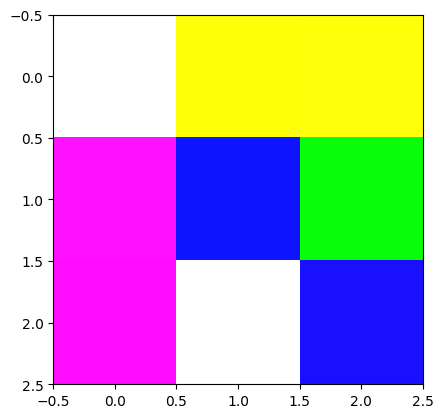

In [35]:
#let's try visualizing the first layer of filters
from mobilenet import MobileNetLarge3D
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display
from matplotlib.animation import FuncAnimation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def state_dict_converter(state_dict):
    for key in list(state_dict.keys()):
        if key.startswith("_orig_mod."):
            new_key = key.replace("_orig_mod.", "")
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    return state_dict

state_dict_36 = torch.load(f'/home/henry/Documents/PythonProjects/old_checkpoints/MobileNetLargeWeighted/MobileNetLarge3D36.pth')
model = MobileNetLarge3D()
model.eval()
model.load_state_dict(state_dict_converter(state_dict_36))
weights = model.block1[0].weight.clone().detach()
for i in range(weights.shape[0]):
    arr = weights[i].cpu().numpy()
    fig,ax = plt.subplots()
    im = ax.imshow(arr[0])
    def update_frame(num):
        im.set_array(arr[num]%arr.shape[-1])
        return [im]
    ani = FuncAnimation(fig, update_frame, frames=range(arr.shape[-1]))
    writergif = imageio.get_writer(f'/home/henry/Documents/PythonProjects/first_layer_filters/first_layer_filter_{i}.gif', mode='I', duration=0.1)
    ani.save(f'/home/henry/Documents/PythonProjects/first_layer_filters/first_layer_filter_{i}.gif', writer=writergif)
    writergif.close()
    plt.close(fig)


In [42]:
'''Calculate the number of parameters in each model, for comparison purposes. 
   Note that movinet is about 2.8x larger than mobilenet small, and mobilenet large is about 2.5x larger than mobilenet small.'''

from movinet import MoViNetA2
from mobilenet import MobileNetLarge3D
movinet = MoViNetA2()
mobilenet_large = MobileNetLarge3D()
mobilenet_small = MobileNetSmall3D()

movinet_params = sum(p.numel() for p in movinet.parameters())
mobilenet_large_params = sum(p.numel() for p in mobilenet_large.parameters())
mobilenet_small_params = sum(p.numel() for p in mobilenet_small.parameters())
print(f"number of parameters in movinet: {movinet_params}")
print(f"number of parameters in mobilenet large: {mobilenet_large_params}")
print(f"number of parameters in mobilenet small: {mobilenet_small_params}")

number of parameters in movinet: 4660762
number of parameters in mobilenet large: 4191584
number of parameters in mobilenet small: 1672816
